In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import Counter
import pandas as pd
from gmail_assistant_llm.util import *

def read_json(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)
    return data

import openpyxl

def read_excel_to_dict(file_path):
    # Load the workbook
    wb = openpyxl.load_workbook(file_path)
    
    # Select the active sheet
    sheet = wb.active
    
    # Initialize the dictionary
    data = {}
    
    # Get the maximum number of rows and columns
    max_row = sheet.max_row
    max_col = sheet.max_column
    
    # Iterate through columns
    for col in range(1, max_col + 1):
        # Get the column header (assuming it's in the first row)
        header = sheet.cell(row=1, column=col).value
        
        # Initialize a list for this column
        data[header] = []
        
        # Iterate through rows in this column, skipping the header
        for row in range(2, max_row + 1):
            cell_value = sheet.cell(row=row, column=col).value
            
            # Only append non-empty cells
            if cell_value is not None:
                data[header].append(cell_value)
    
    return data

job_state = read_excel_to_dict('state.xlsx')

for key in job_state.keys():
    print(key, len(job_state[key]))

job_data = read_json(get_path(os.getenv('JOB_LIST_FINAL')))
print("Total companies: ", len(job_data))

applied 20
discard 74
science 3
network 1
Total companies:  1876


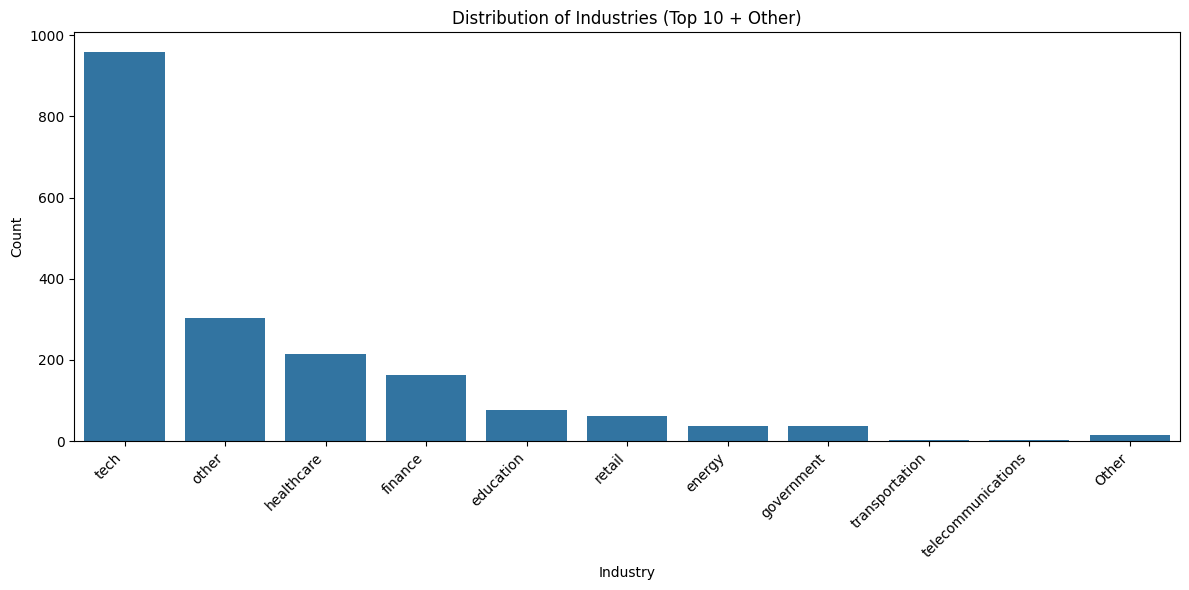

In [2]:
industry = []
for job in job_data:
    industry.append(job['industry'])



# Count the frequencies of each industry
industry_counts = Counter(industry)

# Create a DataFrame from the counts
df = pd.DataFrame.from_dict(industry_counts, orient='index', columns=['count']).reset_index()
df = df.rename(columns={'index': 'industry'})
df = df.sort_values('count', ascending=False)

# Get the top 10 industries
top_10 = df.nlargest(10, 'count')

# Sum the counts of the remaining industries
other_count = df.iloc[10:]['count'].sum()

# Add the "Other" category
other = pd.DataFrame({'industry': ['Other'], 'count': [other_count]})

# Combine top 10 and Other
df_plot = pd.concat([top_10, other])

# Create the bar chart using seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x='industry', y='count', data=df_plot)
plt.title('Distribution of Industries (Top 10 + Other)')
plt.xlabel('Industry')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Display the plot
plt.show()

In [3]:
from fuzzywuzzy import fuzz

def fuzzy_match(name, names_list, threshold=80):
    for comp_name in names_list:
        if fuzz.ratio(name.lower(), comp_name.lower()) >= threshold:
            return comp_name
    return None

def update_df_with_labels(df, job_state, threshold=80):
    # Add new columns for each label and initialize them to False
    for label in job_state.keys():
        df[label] = False
    
    unmatched = {label: [] for label in job_state.keys()}
    
    # Create a dictionary of all companies in df for faster lookup
    df_companies = df['name'].to_dict()
    
    # Update the DataFrame based on the job_state dictionary
    for label, companies in job_state.items():
        for company in companies:
            match = fuzzy_match(company, df_companies.values(), threshold)
            if match:
                # Find the index of the matched company in df
                idx = [k for k, v in df_companies.items() if v == match][0]
                df.at[idx, label] = True
            else:
                unmatched[label].append(company)
    
    return df, unmatched

df = pd.DataFrame(job_data)

threshold = 80  # You can adjust this value

df, unmatched = update_df_with_labels(df, job_state, threshold)

print(df.head())
print(unmatched)


/journel/s0/zur74/venv/gpt_rag/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


        name                                          positions query_status  \
0  Microsoft  [{'name': 'Data and Applied Scientist', 'date'...         done   
1     Google  [{'name': 'Data Scientist, Marketing, Google C...         done   
2      Hinge  [{'name': 'Data Scientist, Growth', 'date': 'F...         done   
3     Amazon  [{'name': 'Applied Scientist', 'date': 'Fri, 2...         done   
4   Cash App  [{'name': 'Machine Learning Engineer (Modeling...         done   

                                             summary industry     size  \
0  Microsoft is a technology company with a missi...     tech   228000   
1  Google is a technology company specializing in...     tech   289181   
2  Hinge is a dating app designed to foster meani...     tech      378   
3  Amazon is a company known for its strong cultu...     tech  1000000   
4  Cash App is a financial services platform that...  finance     3937   

   founding_year                company_url                funding  \
0   

In [6]:
def convert_dates_to_yyyymmdd(df, column_name='recent_update'):
    # Convert the column to datetime, coercing errors to NaT
    df[column_name] = pd.to_datetime(df[column_name], errors='coerce')
    
    # Format the datetime to yyyy/mm/dd string
    df[column_name] = df[column_name].dt.strftime('%Y/%m/%d')
    
    return df
df = convert_dates_to_yyyymmdd(df)


In [9]:
# get current date 
from datetime import datetime

current_date = datetime.now().strftime('%Y%m%d')  # Using YYYYMMDD format for filename

# Save to Excel with current date in filename
excel_filename = f'company_data_{current_date}.xlsx'
df.to_excel(excel_filename, index=False)